# Course Project No 3 - Part 2 - House prices

Let's import all the base libraries that we will use in this Notebook

In [25]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

# Insight:
# Pour les missing values, créer une catégorie missing
# Ne pas supprimer les colonnes en première instance, à faire plus tard dans la construction de modèles simples.
# Utiliser les histogrammes simples pour évaluer les outliers des colonnes numériques.
# Pour les colonnes avec données manquantes, une LinearRegression sera pénalisée alors que les regression type Ridge seront moins sensibles
# Le drop de colonne pourra être évalué avec une approche Grid en jouant sur l'alpha du Ridge (si pas d'influence, on ne doit pas trouver d'outfitting
# en diminuant la valeur de l'alpha)

# !!! Ordinal values: À classer


## Goal of this second part

Estimate the price of 500 houses using a model based on 2'430 house prices, analyzing a dataset made of 82 features

## A quick look at the data

In [26]:
data_df = pd.read_csv(os.path.join('data','house-prices.csv'))
data_df.head(3)

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,484,528275070,60,RL,NaN,8795,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,4,2009,WD,Normal,236000
1,2586,535305120,20,RL,75.0,10170,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,155000
2,2289,923228250,160,RM,21.0,2001,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,75000


## Data cleaning

Data in this set is not optimal and has to be cleaned before being used. Here is the methodology followed.


### Drop useless columns

Order and PID columns are useless to fit models. Drop it :-)

> Note: Instead of dropping column right now, we had the columns to drop in a 'column_to_drop' set to removed them later. This trick allows us to run many cell notebook several time without side effect. Of course, as soon as the drop command is applied on this set, the previous cells might not work and the notebook should be rerun from beginning.

> Note 2: Same for one-hot encoding, we define a 'columns_to_encode' set to perform the one-hot encoding later.

In [27]:
# Store the columns to be dropped
columns_to_drop = set()

# Store the columns to be ont-hot encoded
columns_to_encode = set()

# Function to add columns to be dropped
def addColumnToDropList(columns = []):
    for c in columns:
        columns_to_drop.add(c)
    print("Columns flaged as 'to be removed':", ",".join(columns_to_drop))

# Function to add columns to be one-hot encoded
def addColumnToOneHotEncoding(columns = []):
    for c in columns:
        columns_to_encode.add(c)
    print("Columns flaged as 'to be one-hot encoded':", ",".join(columns_to_encode))


In [28]:
addColumnToDropList(['Order','PID'])

Columns flaged as 'to be removed': PID,Order


### Handle columns with more than 20% empty cells
Some of the columns contains a huge amount of null cells, we should drop them as they won't be pertinent if we were seeking for data quality.
But, in Machine Learning approach, it's a better choice to keep all the data available, modifying it a little bit to suit model fitting process.
Why seeking for 20% of empty cells in columns ? No specific reason, arbitrary choice :-)

Let's identify those columns.

In [29]:
# Number of lines in dataset
total_line = data_df.shape[0]

# NULL_CELL_LIMIT is the max allowed percentage of null value in a column
NULL_CELL_LIMIT = 0.20

# List of columns that we will drop
identified_column = list()

# Loop in each column and identify the one to drop
for c in data_df.columns:
    no_of_null_cell = data_df[c].isnull().sum()
    if(no_of_null_cell/total_line > NULL_CELL_LIMIT):
        identified_column.append(c)

print("Columns with mode than 20% of empty cells:", ','.join(identified_column))

data_df[identified_column].isnull().sum().sort_values(ascending=False)

Columns with mode than 20% of empty cells: Alley,Fireplace Qu,Pool QC,Fence,Misc Feature


Pool QC         2418
Misc Feature    2340
Alley           2267
Fence           1941
Fireplace Qu    1186
dtype: int64

So, we've found 5 columns. Here is what I've decided to do with them.

#### Pool QC: 

On the whole dataset, we found that only 12 houses are equiped with a pool.
Choice is made to do a one-hot encoding on the 'Pool QC' column to simply identify houses with a pool.
Prior to the one-hot encoding, we replace null values with 'no', non null values with 'yes'


In [30]:
# Ensure that number of houses without a pool is in line with the poll size information (only houses with
# a pool should have a pool area above 0)
print("Number of houses with pool:\t",data_df.shape[0] - data_df['Pool QC'].isnull().sum())
print("Number of pool area > 0:\t",data_df[data_df['Pool Area'] > 0]['Pool Area'].count())

# Replace null values in 'Pool QC' by 'no', non null by 'yes', and store it in 'Pool' column
data_df['Pool'] = np.where(data_df['Pool QC'].isnull(), 'no', 'yes')

# Do a one hot encoding on 'Pool' and drop 'Pool QC'
addColumnToOneHotEncoding(['Pool'])
addColumnToDropList(['Pool QC'])


Number of houses with pool:	 12
Number of pool area > 0:	 12
Columns flaged as 'to be one-hot encoded': Pool
Columns flaged as 'to be removed': PID,Order,Pool QC


#### Alley
NaN means house without alley. We should split the 'Alley' information into two different one: Does the house has an alley, and what type is the alley.
Do a hot encoding on alley to get the 'Alley Type' for each house, and another one-hot encoding on 'Alley' to get the allay exists category. For the alley_exists one hot encoding, we must replace non NaN value with 'yes', and NaN values with 'no' prior to the one-hot encoding process.


In [31]:
# Duplicate 'Alley' column to 'Alley Type'
data_df['Alley Type'] = data_df['Alley']

# Replace null values in 'Alley' by 'no', non null by 'yes'
data_df['Alley Exists'] = np.where(data_df['Alley'].isnull(), 'no', 'yes')

# Do a one hot encoding on 'Allay Type' and 'Alley'
addColumnToOneHotEncoding(['Alley Type', 'Alley Exists'])
addColumnToDropList(['Alley'])


Columns flaged as 'to be one-hot encoded': Pool,Alley Exists,Alley Type
Columns flaged as 'to be removed': PID,Alley,Order,Pool QC


#### Misc Feature

Misc Feature store informations on features that do not match any other columns. Approach here is to perform a simple 'one-hot' encoding which will remove the null values.

In [32]:
addColumnToOneHotEncoding(['Misc Feature'])

Columns flaged as 'to be one-hot encoded': Pool,Misc Feature,Alley Exists,Alley Type


#### Fence

Fence information should be used to reflect only if the house has a fence or not. Other informations are not relevant.

In [33]:
print("Details on the 'Fence' column content:")
print(data_df[['Fence','PID']].groupby('Fence').count().sort_values('PID', ascending=False))

# Create 'Has Fence'
data_df['Has Fence'] = np.where(data_df['Fence'].isnull(), 'no', 'yes')

# Drop 'Fence' and one-hot encode 'Has Fence'
addColumnToDropList(['Fence'])
addColumnToOneHotEncoding(['Has Fence'])

Details on the 'Fence' column content:
       PID
Fence     
MnPrv  288
GdPrv   97
GdWo    94
MnWw    10
Columns flaged as 'to be removed': Order,Fence,PID,Alley,Pool QC
Columns flaged as 'to be one-hot encoded': Pool,Misc Feature,Alley Exists,Has Fence,Alley Type


#### Fireplace Qu

We use the same approach as Pools for Fireplaces.

First check that number of houses with a Fireplace Quality not null is equal to the number of houses with a number of Fireplace above 0.

As it is the case, then create a 'Fireplace Exist' column and one-hot encode 'Fireplace Qu'

In [35]:
# Ensure that number of houses without a pool is in line with the poll size information (only houses with
# a pool should have a pool area above 0)
print("Number of houses with fireplace quality evaluation:\t",data_df.shape[0] - data_df['Fireplace Qu'].isnull().sum())
print("Number of houses with at least one fireplace:\t",data_df[data_df['Fireplaces'] > 0]['Fireplaces'].count())

# Replace null values in 'Pool QC' by 'no', non null by 'yes', and store it in 'Pool' column
data_df['Fireplace Exists'] = np.where(data_df['Fireplace Qu'].isnull(), 'no', 'yes')

# Do a one hot encoding on 'Pool' and drop 'Pool QC'
addColumnToOneHotEncoding(['Fireplace Exists','Fireplace Qu'])


Number of houses with fireplace quality evaluation:	 1244
Number of houses with at least one fireplace:	 1244
Columns flaged as 'to be one-hot encoded': Pool,Fireplace Exists,Misc Feature,Alley Exists,Has Fence,Alley Type,Fireplace Qu


#### One-hot encode and drop columns identified previously

It's now time to 'one-hot' encode and drop identified columns above.

> Note: One-hot encoding must be done prior to the drop call as some of the flagged columns to be dropped are created by the 'one-hot' encoding process.

In [36]:
data_df= pd.get_dummies(data_df, columns=columns_to_encode)

data_df.drop(columns_to_drop, axis=1, inplace=True)


### Remove lines with empty cells on columns with a few empty values

Some of the remaining column after this first cleaning still contains empty cells. Decision is made to drop all the lines that contains null values in the columns where the total number of null values in those columns is not null and lower than a fixed value.

To evaluate the fixed value, we will try different one and maesure how much line will be dropped. If the result is less the 20%, then it's a good choice. 20% of the test dataframe represents around 80% of the test dataset, which is an acceptable factor.


In [37]:
# Sum number of empty cells per column
null_sum_df = data_df.isnull().sum().to_frame()

# A dictionnary that will contain the different dataframe
data_df_list = dict()

for i in (10, 100, 200, 300, 400, 500):
    columns_df = null_sum_df[np.logical_and(null_sum_df[0] > 0, null_sum_df[0] < i)]
    bool_filter = data_df[columns_df.index.values.tolist()].isnull().values.any(axis=1)
    data_df_list[i] = data_df[np.logical_not(bool_filter)]
    df_size = data_df_list[i].shape[0]
    print("Resulting size of the Dataframe (factor = {:3}) = {}/{} (ratio = {:.2f}%)".format(i,df_size,data_df.shape[0],(df_size/data_df.shape[0])*100))


Resulting size of the Dataframe (factor =  10) = 2426/2430 (ratio = 99.84%)
Resulting size of the Dataframe (factor = 100) = 2333/2430 (ratio = 96.01%)
Resulting size of the Dataframe (factor = 200) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 300) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 400) = 2209/2430 (ratio = 90.91%)
Resulting size of the Dataframe (factor = 500) = 1815/2430 (ratio = 74.69%)


According to our previous test, if we drop all the lines where, in the corresponding columns, the number of empty cells are not null and below 400, we do remove around 200 lines, which is acceptable. Our dataframe should now take the value data_df_list[400].

And finally, we remain with only one column containing null values: Lot Frontage

In [38]:
data_df = data_df_list[400].copy()

# Display columns with empty values, sorted descending
data_df.isnull().sum().to_frame().sort_values(0, ascending = False).head(3)

,0
Lot Frontage,394
MS SubClass,0
Garage Qual,0


Let's have a look at thisd column to determine what to do with empty cells.

Best option at that time, draw an histogram graph:

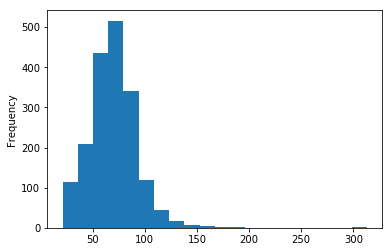

In [39]:
data_df['Lot Frontage'].plot.hist(bins=20)
plt.show()

Previous graph shows that we have some outliers in this columns, and most of the datapoints are centered on a value around 60.

The approach we can choose to handle null values in this column is to replace them by the mean value of the column, without the outliers and null values. See below the new histogram and the mean value calculated. This value will be used to replace null values in that column.

Mean value calculated with the reduced dataset: 68.79


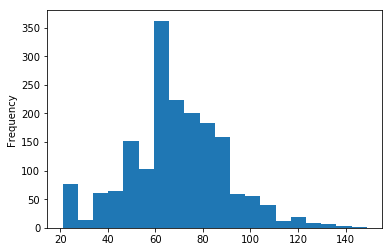

In [40]:
data_df['Lot Frontage'][np.logical_and(data_df['Lot Frontage'] < 150, data_df['Lot Frontage'] > 0)].plot.hist(bins=20)
mean_value = data_df['Lot Frontage'][np.logical_and(data_df['Lot Frontage'] < 150, data_df['Lot Frontage'] > 0)].mean()
print("Mean value calculated with the reduced dataset: {:.2f}".format(mean_value))



In [41]:
data_df['Lot Frontage Clean'] = data_df['Lot Frontage'].fillna(int(mean_value))

# do not forget to drop the orignal column
data_df = data_df.drop('Lot Frontage', axis=1)

print("Number of null value in dataframe:", data_df.isnull().sum().sum())
print("Dataframe size:", data_df.shape)
print("Good :-)")


Number of null value in dataframe: 0
Dataframe size: (2209, 95)
Good :-)


Fine. Our dataset has now 0 null values. It's time now to perform feature encoding and feature engineering 

Before that, let's classify columns in four categories using the documentation provided with the dataset. Goal is to build 4 list of column names, one for each type: continuous, nominal, ordinal and discrete.

In [52]:


# Continuous variables
continuous_column = [
    '1st Flr SF', '2nd Flr SF', 'Lot Frontage Clean', 'Lot Area', 'Mas Vnr Area', 'Bsmt Unf SF', 'BsmtFin SF 1', 'BsmtFin SF 2', 'Total Bsmt SF',
    'Low Qual Fin SF', 'Gr Liv Area', 'Garage Area', '3Ssn Porch', 'Open Porch SF', 'Wood Deck SF', 'Pool Area', 'Screen Porch', 'Misc Val', 'Enclosed Porch',
]

# Nominal variables - no possible ordering
nominal_column = [
    'MS SubClass', 'MS Zoning', 'Street', 'Land Contour', 'Lot Config', 'Neighborhood', 'Condition 1', 'Condition 2', 'Bldg Type', 'House Style', 'Exterior 1st',
    'Exterior 2nd', 'Roof Matl', 'Roof Style', 'Mas Vnr Type', 'Foundation', 'Heating', 'Central Air', 'Garage Type', 'Sale Condition', 'Sale Type', 'Street', 'Alley',
]

# Ordinal variables - you can order the categories
ordinal_column =[
    'Lot Shape', 'Utilities', 'Land Slope', 'Overall Cond', 'Overall Qual', 'Exter Cond', 'Exter Qual', 'Bsmt Cond', 'Bsmt Qual', 'Bsmt Exposure', 'BsmtFin Type 1',
    'BsmtFin Type 2', 'Heating QC', 'Electrical', 'Kitchen Qual', 'Functional', 'Garage Finish', 'Garage Cond', 'Garage Qual', 'Paved Drive',
]

# Discrete variables - categories are integer values
discrete_column = [
    'Year Built', 'Year Remod/Add', 'Mo Sold', 'Yr Sold', 'Full Bath', 'Bsmt Full Bath', 'Bsmt Half Bath', 'Half Bath', 'TotRms AbvGrd', 'Fireplaces',
    'Garage Yr Blt', 'Garage Cars', 'Bedroom AbvGr', 'Kitchen AbvGr',
]

y_column = [
 'SalePrice',
]

# This trick should return an the columns we've one-hot encoded above, number of these should be 20
unclassified_columns = set(data_df.columns.values.tolist()) - set(continuous_column) - set(nominal_column) - set(ordinal_column) - set(discrete_column) - set(y_column)
print("Number of column not classified:",len(unclassified_columns))
print("Column names:",','.join(sorted(unclassified_columns)))

Number of column not classified: 20
Column names: Alley Exists_no,Alley Exists_yes,Alley Type_Grvl,Alley Type_Pave,Fireplace Exists_no,Fireplace Exists_yes,Fireplace Qu_Ex,Fireplace Qu_Fa,Fireplace Qu_Gd,Fireplace Qu_Po,Fireplace Qu_TA,Has Fence_no,Has Fence_yes,Misc Feature_Elev,Misc Feature_Gar2,Misc Feature_Othr,Misc Feature_Shed,Misc Feature_TenC,Pool_no,Pool_yes


## Feature encoding

In [53]:
for c in data_df.select_dtypes(np.number):
    c_mean = data_df[c].mean()
    c_std  = data_df[c].std()
    z_min  = (c_mean-data_df[c].min())/c_std
    z_max  = (data_df[c].max()-c_mean)/c_std
    outliers = ''
    if (z_min > 2 or z_max > 2):
        outliers = '(outliers)'
    #print("Column {:20s} mean:{:9.2f}\tstd:{:9.2f}\tz-min:{:9.2f}\tz-max:{:10.2f} {}".format(c, c_mean, c_std, z_min, z_max, outliers))
    

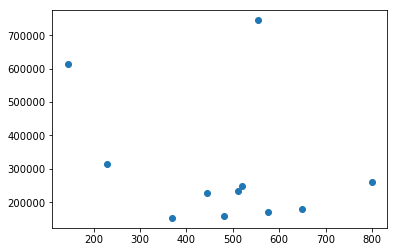

In [30]:
data_df['Pool Area'].sort_values(ascending=False)
temp_df = data_df[data_df['Pool Area'] > 0]
plt.scatter(temp_df['Pool Area'], temp_df['SalePrice'])

<Figure size 1080x720 with 0 Axes>

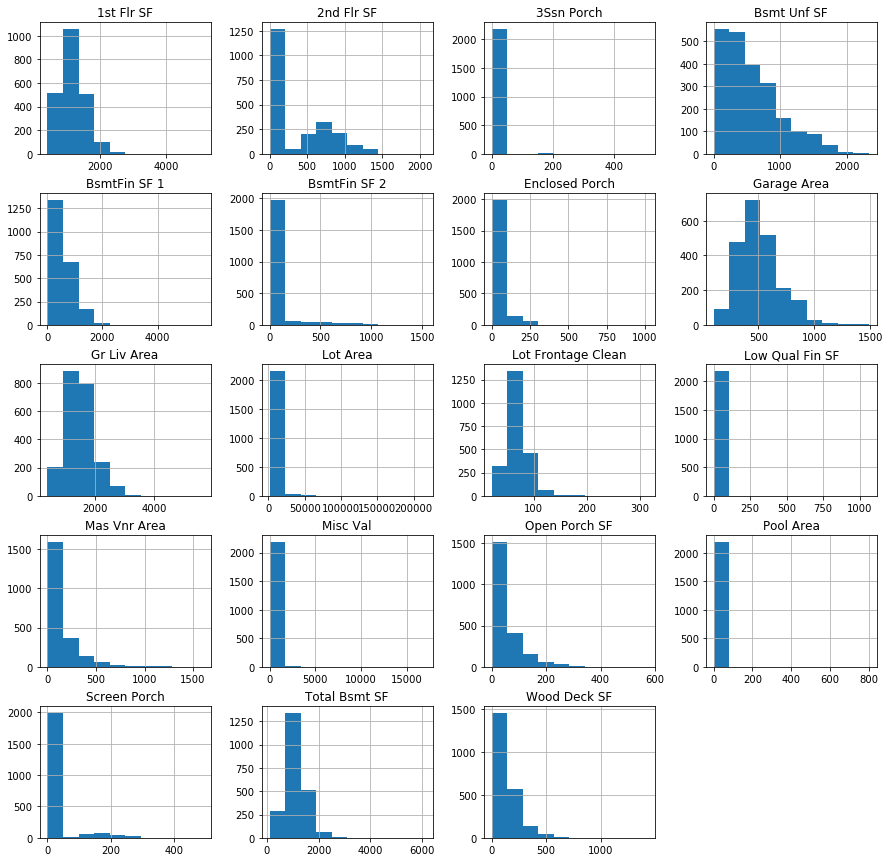

In [22]:
plt.figure(figsize=(15,10))
data_df[continuous_column].hist(figsize=(15,15))
plt.show()

## Feature encoding

> Question: What is the difference between feature encoding and feature engineering ?

## Feature engineering

## Model fitting

## Regularization

## Communicating the results

## Compute predictions

## Evaluate your predictions